# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from scipy.stats import ks_2samp

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve

In [38]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [39]:
# Separar os três últimos meses como safras de validação out of time (oot), utilizadno a data máxima como referência
oot = df[df['data_ref'] >= (df['data_ref'].max() - pd.DateOffset(months=3))]
oot

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
550000,2015-12-01,11675,M,S,S,0,Assalariado,Superior completo,Casado,Casa,44,13.082192,2.0,45242.72,False
550001,2015-12-01,5595,F,N,N,0,Assalariado,Médio,Casado,Casa,40,2.871233,2.0,892.44,False
550002,2015-12-01,7725,M,S,S,0,Assalariado,Médio,Casado,Casa,51,32.619178,2.0,74949.48,False
550003,2015-12-01,509,M,S,S,0,Assalariado,Médio,Casado,Casa,45,11.865753,2.0,7910.84,False
550004,2015-12-01,13736,M,S,S,2,Servidor público,Médio,Casado,Estúdio,35,10.876712,4.0,11652.96,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,2016-03-01,13689,M,N,S,0,Empresário,Superior completo,Casado,Casa,48,3.038356,2.0,2109.99,False
749996,2016-03-01,7000,F,N,S,0,Pensionista,Médio,Solteiro,Casa,65,NaN,1.0,1389.39,False
749997,2016-03-01,14023,M,S,N,2,Assalariado,Médio,Casado,Casa,43,10.375342,4.0,649.06,True
749998,2016-03-01,2396,F,N,S,0,Assalariado,Médio,Viúvo,Casa,56,13.780822,1.0,4216.72,True


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [40]:
df.data_ref.value_counts()

2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: data_ref, dtype: int64

In [41]:
# Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
# Descrição geral da base de dados
total_rows = df.shape[0]
total_columns = df.shape[1]

# Contagem de linhas por mês em 'data_ref'
rows_per_month = df['data_ref'].value_counts().sort_index()

total_rows, total_columns, rows_per_month



(750000,
 15,
 2015-01-01    50000
 2015-02-01    50000
 2015-03-01    50000
 2015-04-01    50000
 2015-05-01    50000
 2015-06-01    50000
 2015-07-01    50000
 2015-08-01    50000
 2015-09-01    50000
 2015-10-01    50000
 2015-11-01    50000
 2015-12-01    50000
 2016-01-01    50000
 2016-02-01    50000
 2016-03-01    50000
 Name: data_ref, dtype: int64)

In [42]:
# Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.
# Variáveis quantitativas
quantitative_vars = df.select_dtypes(include=['int64', 'float64']).drop(['index'], axis=1)
quantitative_desc = quantitative_vars.describe()

# Variáveis qualitativas
qualitative_vars = df.select_dtypes(include=['object', 'bool'])
qualitative_desc = qualitative_vars.describe()

print(f"Variáveis quantitativas \n {quantitative_desc}")
print(f"Variáveis qualitativas \n {qualitative_desc}")


Variáveis quantitativas 
           qtd_filhos          idade  tempo_emprego  qt_pessoas_residencia  \
count  750000.000000  750000.000000  624043.000000          750000.000000   
mean        0.433251      43.804733       7.748574               2.212241   
std         0.739379      11.229868       6.687455               0.903428   
min         0.000000      22.000000       0.117808               1.000000   
25%         0.000000      34.000000       3.049315               2.000000   
50%         0.000000      43.000000       6.046575               2.000000   
75%         1.000000      53.000000      10.183562               3.000000   
max        14.000000      68.000000      42.906849              15.000000   

              renda  
count  7.500000e+05  
mean   2.323854e+04  
std    7.910601e+04  
min    1.076700e+02  
25%    3.467700e+03  
50%    7.861820e+03  
75%    1.831828e+04  
max    4.083986e+06  
Variáveis qualitativas 
           sexo posse_de_veiculo posse_de_imovel   tipo_re

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

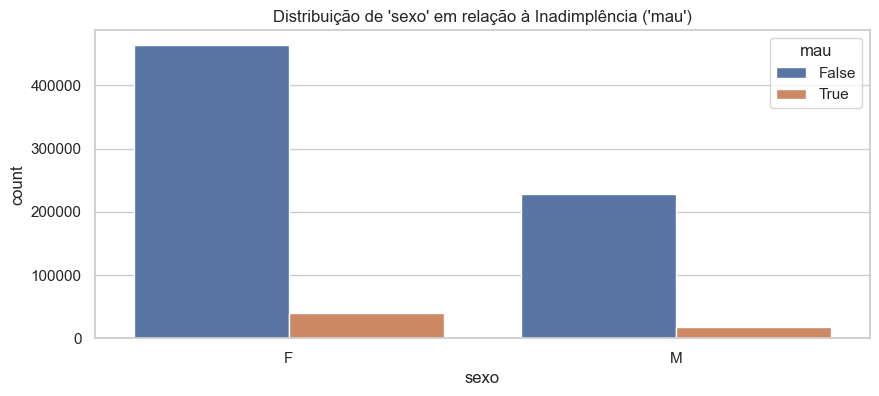

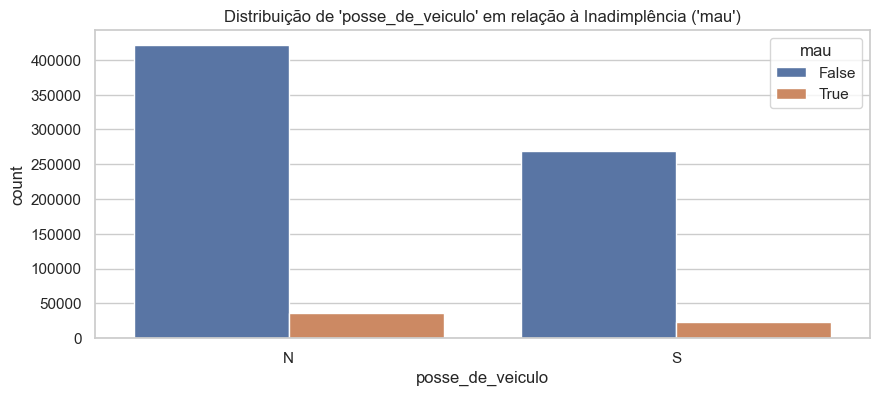

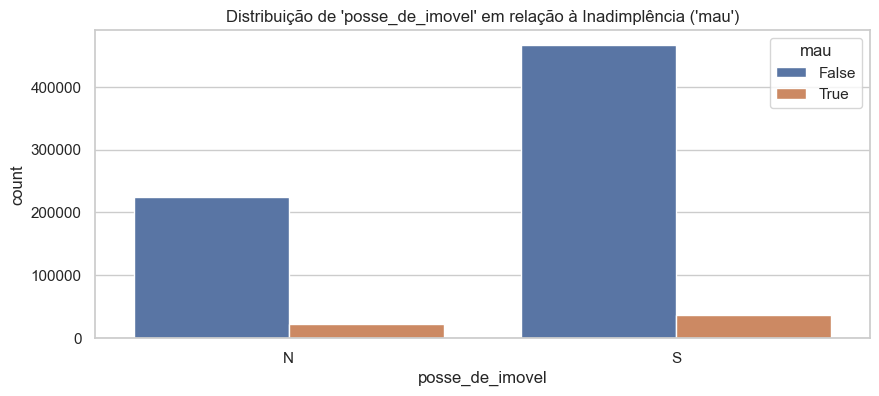

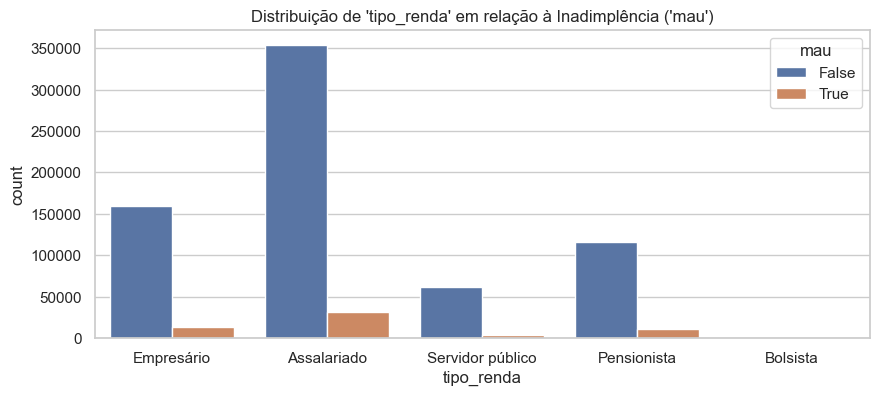

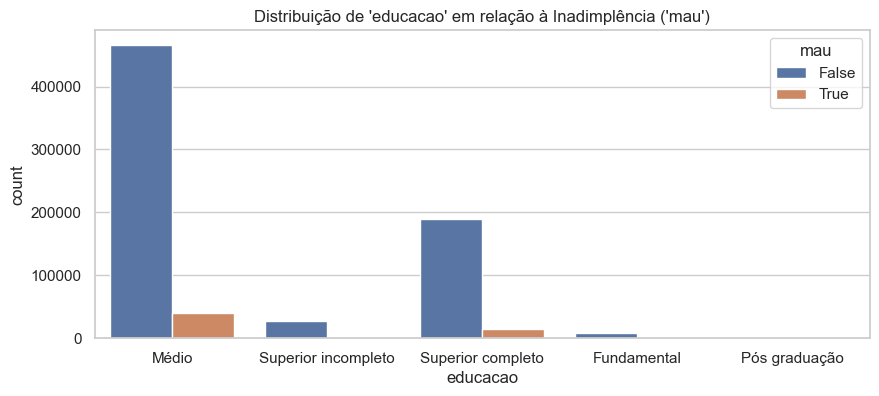

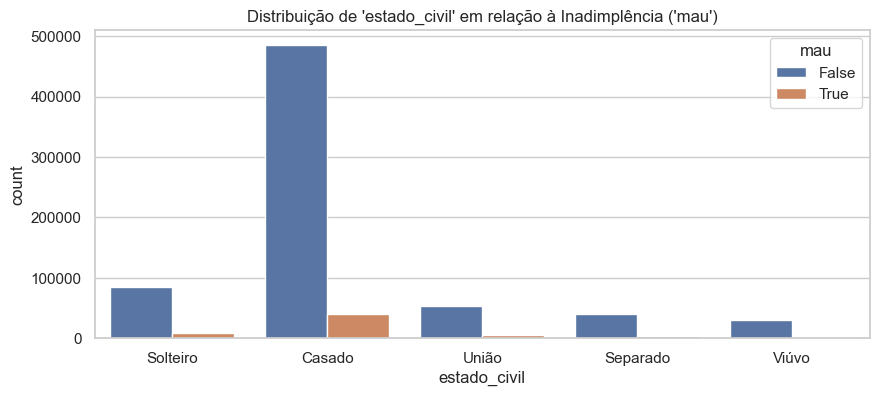

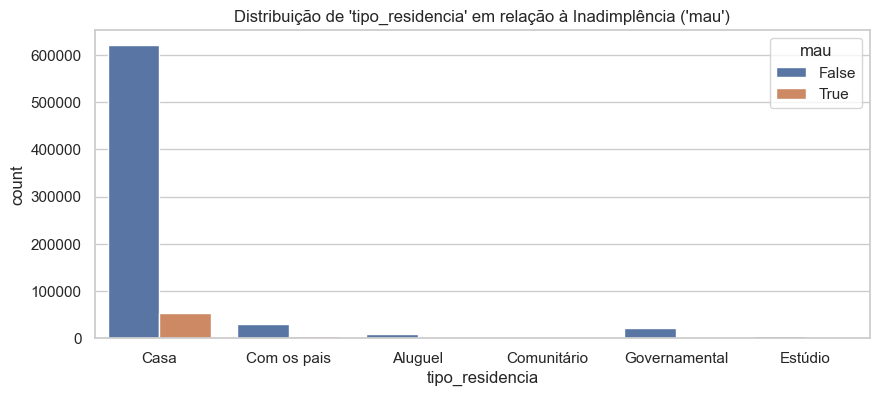

In [43]:
# Para as variáveis quantitativas
sns.set(style="whitegrid")

# Análise bivariada para variáveis qualitativas
for column in qualitative_vars.columns:
    if column != 'mau':  # Excluindo a própria variável alvo
        plt.figure(figsize=(10, 4))
        sns.countplot(x=column, hue="mau", data=df)
        plt.title(f"Distribuição de '{column}' em relação à Inadimplência ('mau')")
        plt.show()


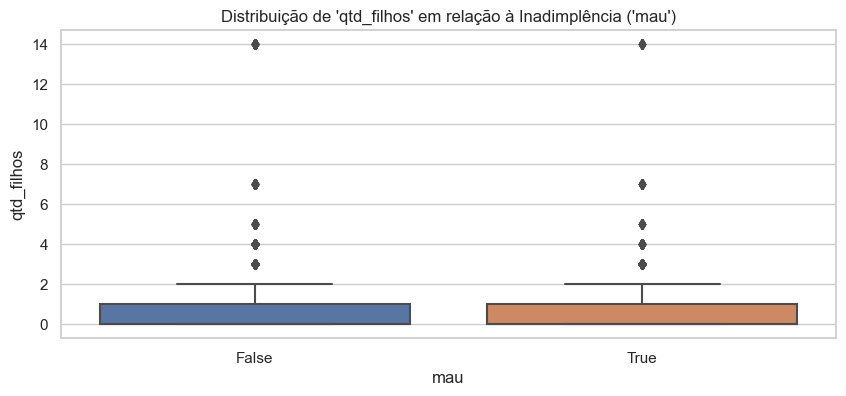

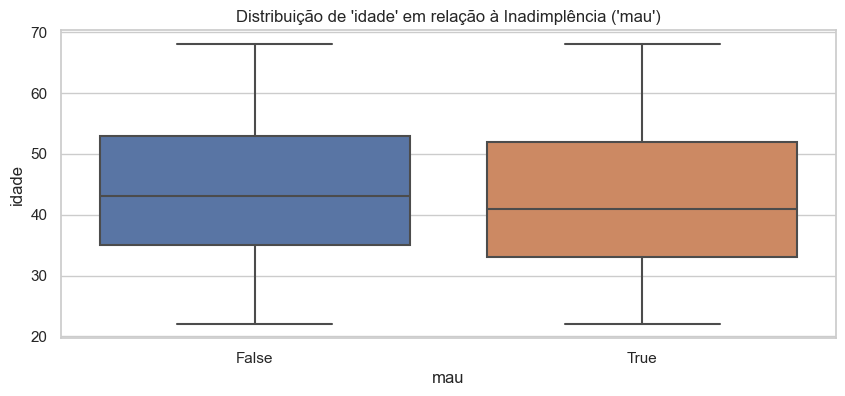

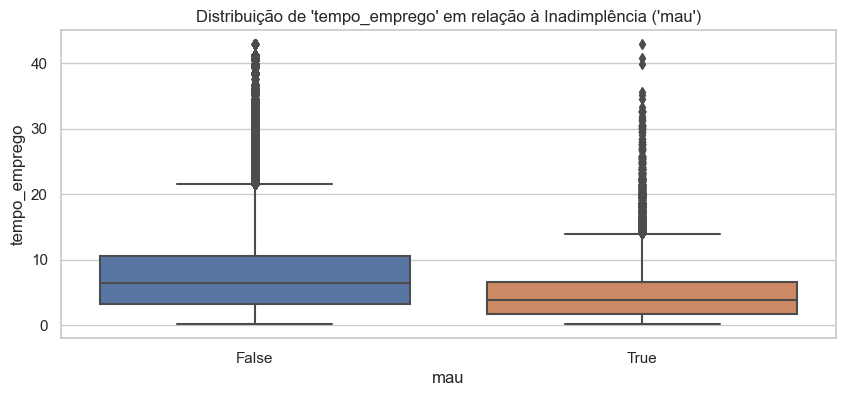

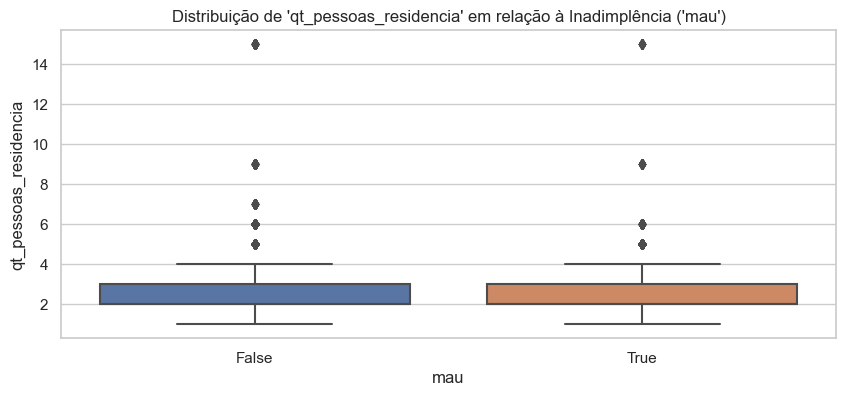

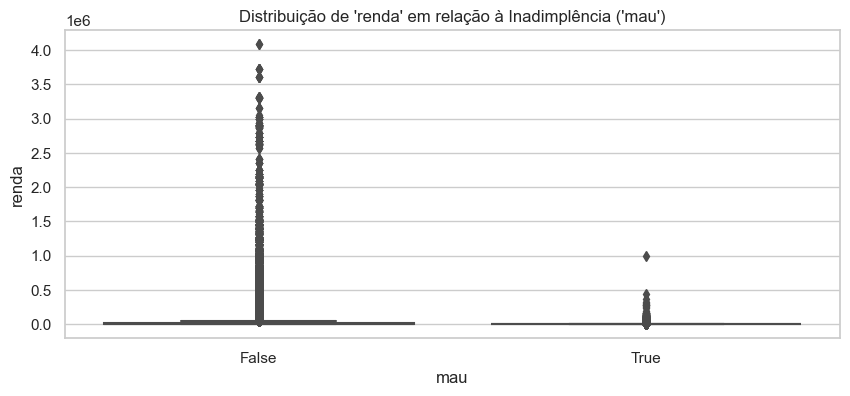

In [44]:
# Análise bivariada para variáveis quantitativas
for column in quantitative_vars.columns:
    if column != 'mau':  # Excluindo a própria variável alvo
        plt.figure(figsize=(10, 4))
        sns.boxplot(x="mau", y=column, data=df)
        plt.title(f"Distribuição de '{column}' em relação à Inadimplência ('mau')")
        plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [45]:
# Identificando valores missing no conjunto de dados
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]  # Filtrar apenas as variáveis com missing values
missing_values_percentage = (missing_values / len(df)) * 100

missing_values, missing_values_percentage


(tempo_emprego    125957
 dtype: int64,
 tempo_emprego    16.794267
 dtype: float64)

In [46]:
# Substituindo valores ausentes em 'tempo_emprego' pela mediana
median_tempo_emprego = df['tempo_emprego'].median()
df['tempo_emprego'].fillna(median_tempo_emprego, inplace=True)

# Verificar se ainda existem valores ausentes
df.isnull().sum().max()


0

In [47]:
# Função para calcular IQR e identificar outliers
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = ((df[column] < lower_bound) | (df[column] > upper_bound))
    return outliers

# Identificando outliers em cada variável quantitativa
outliers_dict = {column: detect_outliers(df, column) for column in quantitative_vars.columns}

# Calculando o número total de outliers por variável
outliers_count = {column: outliers.sum() for column, outliers in outliers_dict.items()}
outliers_count


{'qtd_filhos': 10016,
 'idade': 0,
 'tempo_emprego': 57123,
 'qt_pessoas_residencia': 9629,
 'renda': 79072}

In [48]:
# Limitando os outliers
for column in quantitative_vars.columns:
    if column != 'idade':  # 'idade' não tem outliers
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

# Verificando novamente a presença de outliers após a limitação
outliers_dict_post = {column: detect_outliers(df, column) for column in quantitative_vars.columns}
outliers_count_post = {column: outliers.sum() for column, outliers in outliers_dict_post.items()}
outliers_count_post


{'qtd_filhos': 0,
 'idade': 0,
 'tempo_emprego': 0,
 'qt_pessoas_residencia': 0,
 'renda': 0}

In [49]:
# Contando o número de zeros em algumas variáveis quantitativas
zero_counts = {column: (df[column] == 0).sum() for column in quantitative_vars.columns}
zero_counts


{'qtd_filhos': 517331,
 'idade': 0,
 'tempo_emprego': 0,
 'qt_pessoas_residencia': 0,
 'renda': 0}

In [50]:
# Verificando a distribuição das categorias em cada variável qualitativa
category_distributions = {column: df[column].value_counts() for column in qualitative_vars.columns}
category_distributions


{'sexo': F    504580
 M    245420
 Name: sexo, dtype: int64,
 'posse_de_veiculo': N    457954
 S    292046
 Name: posse_de_veiculo, dtype: int64,
 'posse_de_imovel': S    503692
 N    246308
 Name: posse_de_imovel, dtype: int64,
 'tipo_renda': Assalariado         385740
 Empresário          172712
 Pensionista         126265
 Servidor público     64922
 Bolsista               361
 Name: tipo_renda, dtype: int64,
 'educacao': Médio                  506836
 Superior completo      204306
 Superior incompleto     29471
 Fundamental              8575
 Pós graduação             812
 Name: educacao, dtype: int64,
 'estado_civil': Casado      526472
 Solteiro     91659
 União        57685
 Separado     42571
 Viúvo        31613
 Name: estado_civil, dtype: int64,
 'tipo_residencia': Casa             674294
 Com os pais       33232
 Governamental     23440
 Aluguel           10349
 Estúdio            5395
 Comunitário        3290
 Name: tipo_residencia, dtype: int64,
 'mau': False    691357
 Tru

In [51]:
# Agrupando categorias em algumas variáveis qualitativas

# Tipo de Renda: Agrupando 'Bolsista' em 'Outros'
df['tipo_renda'] = df['tipo_renda'].replace('Bolsista', 'Outros')

# Educação: Agrupando 'Fundamental', 'Superior incompleto' e 'Pós graduação' em 'Outros'
education_groups = ['Fundamental', 'Superior incompleto', 'Pós graduação']
df['educacao'] = df['educacao'].replace(education_groups, 'Outros')

# Estado Civil: Agrupando 'Separado' e 'Viúvo' em 'Outros'
civil_status_groups = ['Separado', 'Viúvo']
df['estado_civil'] = df['estado_civil'].replace(civil_status_groups, 'Outros')

# Tipo de Residência: Agrupando 'Estúdio' e 'Comunitário' em 'Outros'
residence_type_groups = ['Estúdio', 'Comunitário']
df['tipo_residencia'] = df['tipo_residencia'].replace(residence_type_groups, 'Outros')

# Verificando a nova distribuição das categorias após o agrupamento
new_category_distributions = {column: df[column].value_counts() for column in qualitative_vars.columns}
new_category_distributions


{'sexo': F    504580
 M    245420
 Name: sexo, dtype: int64,
 'posse_de_veiculo': N    457954
 S    292046
 Name: posse_de_veiculo, dtype: int64,
 'posse_de_imovel': S    503692
 N    246308
 Name: posse_de_imovel, dtype: int64,
 'tipo_renda': Assalariado         385740
 Empresário          172712
 Pensionista         126265
 Servidor público     64922
 Outros                 361
 Name: tipo_renda, dtype: int64,
 'educacao': Médio                506836
 Superior completo    204306
 Outros                38858
 Name: educacao, dtype: int64,
 'estado_civil': Casado      526472
 Solteiro     91659
 Outros       74184
 União        57685
 Name: estado_civil, dtype: int64,
 'tipo_residencia': Casa             674294
 Com os pais       33232
 Governamental     23440
 Aluguel           10349
 Outros             8685
 Name: tipo_residencia, dtype: int64,
 'mau': False    691357
 True      58643
 Name: mau, dtype: int64}

In [52]:
# Criando faixas etárias
bins = [0, 25, 35, 45, 55, 65, float('inf')]
labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '65+']
df['idade_grupo'] = pd.cut(df['idade'], bins=bins, labels=labels, right=False)

# Verificando a distribuição da nova variável 'idade_grupo'
age_group_distribution = df['idade_grupo'].value_counts().sort_index()
age_group_distribution


18-25      6846
26-35    183420
36-45    217466
46-55    183317
56-65    141883
65+       17068
Name: idade_grupo, dtype: int64

In [53]:

# Preparando os dados para o modelo
X = df.drop(['data_ref', 'index', 'mau', 'idade'], axis=1)  # Excluindo 'data_ref', 'index', 'mau' e 'idade' (usamos 'idade_grupo')
y = df['mau'].astype(int)  # Convertendo a variável alvo para tipo inteiro (0 e 1)

# Codificando variáveis categóricas
X = pd.get_dummies(X, drop_first=True)

# Dividindo os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Construindo o modelo de regressão logística
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Exibindo os coeficientes do modelo
coeficientes = pd.Series(logreg.coef_[0], index=X_train.columns)
intercept = logreg.intercept_[0]

coeficientes, intercept


(qtd_filhos                       0.228325
 tempo_emprego                   -0.027654
 qt_pessoas_residencia           -0.219924
 renda                           -0.000145
 sexo_M                          -0.140852
 posse_de_veiculo_S               0.027273
 posse_de_imovel_S               -0.045485
 tipo_renda_Empresário           -0.074289
 tipo_renda_Outros               -0.000069
 tipo_renda_Pensionista          -0.070930
 tipo_renda_Servidor público     -0.025160
 educacao_Outros                 -0.035202
 educacao_Superior completo      -0.071998
 estado_civil_Outros             -0.170056
 estado_civil_Solteiro           -0.221653
 estado_civil_União               0.005715
 tipo_residencia_Casa            -0.182753
 tipo_residencia_Com os pais     -0.111630
 tipo_residencia_Governamental   -0.075223
 tipo_residencia_Outros          -0.023419
 idade_grupo_26-35               -0.120446
 idade_grupo_36-45               -0.091040
 idade_grupo_46-55               -0.094997
 idade_grup

In [54]:
report = classification_report(y_test, logreg.predict(X_test), zero_division=0)
print(report)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96    207295
           1       0.00      0.00      0.00     17705

    accuracy                           0.92    225000
   macro avg       0.46      0.50      0.48    225000
weighted avg       0.85      0.92      0.88    225000


In [55]:
# Adicionando uma constante ao conjunto de dados (necessário para o modelo statsmodels)
X_train_sm = sm.add_constant(X_train)

# Construindo o modelo de regressão logística com statsmodels
logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit()

# Exibindo o resumo do modelo, incluindo os valores-p
model_summary = result.summary()
print(model_summary)

Optimization terminated successfully.
         Current function value: 0.241754
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                    mau   No. Observations:               525000
Model:                          Logit   Df Residuals:                   524974
Method:                           MLE   Df Model:                           25
Date:                Thu, 18 Jan 2024   Pseudo R-squ.:                  0.1170
Time:                        11:48:46   Log-Likelihood:            -1.2692e+05
converged:                       True   LL-Null:                   -1.4375e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -1.3669      0.193     -7.077      0.

1. **Variáveis Significativas**:
   - `tempo_emprego`: Coeficiente negativo, indicando que um maior tempo de emprego está associado a uma menor probabilidade de inadimplência.
   - `renda`: Coeficiente negativo, sugerindo que uma maior renda está associada a uma menor probabilidade de inadimplência.
   - `tipo_renda_Pensionista`: Coeficiente negativo, indicando que ser pensionista está associado a uma menor probabilidade de inadimplência.
   - `idade_grupo_36-45`: Coeficiente negativo, indicando que pertencer a esta faixa etária está associado a uma menor probabilidade de inadimplência em comparação com o grupo base (18-25 anos).

2. **Variáveis Não Significativas**:
   - Variáveis como `qtd_filhos`, `sexo_M`, `posse_de_veiculo_S`, e muitas outras mostraram valores-p altos, indicando que não há evidência suficiente para afirmar que estas variáveis têm um impacto significativo na previsão de inadimplência.

É importante notar que a significância estatística não é o único fator a ser considerado ao avaliar a importância de uma variável em um modelo preditivo. Aspectos como a relevância prática, a interpretabilidade e o conhecimento do domínio também são importantes.

A presença de variáveis não significativas pode indicar que elas não contribuem de maneira útil para o modelo ou que suas relações com a variável alvo são mais complexas do que o modelo linear pode capturar. Em uma análise mais aprofundada, pode-se considerar remover ou substituir variáveis não significativas para simplificar o modelo e potencialmente melhorar seu desempenho.

In [58]:
# Removendo variáveis não significativas
# Identificando as variáveis com valor-p > 0,05 (não significativas)
p_values = result.pvalues
non_significant_vars = p_values[p_values > 0.05].index

# Removendo a constante do conjunto de variáveis não significativas
#non_significant_vars = non_significant_vars.drop('const')

# Atualizando os conjuntos de dados para excluir as variáveis não significativas
X_train_significant = X_train.drop(columns=non_significant_vars)
X_test_significant = X_test.drop(columns=non_significant_vars)

# Reconstruindo o modelo com apenas variáveis significativas
logreg_significant = LogisticRegression(max_iter=1000)
logreg_significant.fit(X_train_significant, y_train)

# Exibindo os coeficientes do novo modelo
coeficientes_significativos = pd.Series(logreg_significant.coef_[0], index=X_train_significant.columns)
intercept_significativo = logreg_significant.intercept_[0]

print(f"Intercepto: {intercept_significativo}")
print(f"Coeficientes: \n {coeficientes_significativos}")

Intercepto: -1.0222028953930133
Coeficientes: 
 tempo_emprego                -0.028229
renda                        -0.000146
sexo_M                       -0.113232
posse_de_veiculo_S            0.080146
posse_de_imovel_S            -0.190082
tipo_renda_Empresário        -0.115590
tipo_renda_Pensionista       -0.169341
educacao_Superior completo   -0.091485
dtype: float64


## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [61]:

# Fazendo previsões com o modelo ajustado no conjunto de teste
y_pred = logreg_significant.predict(X_test_significant)
y_pred_proba = logreg_significant.predict_proba(X_test_significant)[:, 1]

# Calculando a acurácia
accuracy = accuracy_score(y_test, y_pred)

# Calculando o índice de Gini
gini = 2 * roc_auc_score(y_test, y_pred_proba) - 1

# Calculando a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculando a estatística KS
ks_statistic = max(tpr - fpr)

accuracy, gini, ks_statistic


(0.9213111111111111, 0.5485346706363505, 0.41412461816442653)

Acurácia: Aproximadamente 92%. Isso indica que o modelo foi capaz de prever corretamente a inadimplência em 92% dos casos no conjunto de teste.

Índice de Gini: Aproximadamente 0.54. O índice de Gini varia de -1 (pior) a 1 (melhor), com 0 indicando um modelo que não tem capacidade de discriminação. Um índice de 0.54 indica uma boa capacidade de discriminação.

Estatística KS: Aproximadamente 0.41. A estatística KS varia de 0 a 1, com valores mais altos indicando melhor capacidade do modelo de distinguir entre as classes (inadimplentes e não inadimplentes). Um valor de 0.41 sugere uma capacidade razoável do modelo em separar as duas classes.
